In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as img
import sys

def load_jsd(filename) :
    y = []
    x = []
    with open(filename) as file :
        for line in file :
            x.append(float(line.split(" ")[0]))
            y.append(float(line.split(" ")[1]))
    return x,y

In [3]:
def plot_map(files, pos=0):
    fig1, ax1 = plt.subplots()
    plt.xlim(-5,5)
    plt.ylim(-5,5)
    if (not (type(files) is list)):
        files=[files]
    pointx=[]
    pointy=[]
    for rf in files:
        f=open(rf)
        for l in f.readlines():
            l=l.rstrip()
            lc=list(map(float, l.split(" ")))
            pointx.append(lc[0+pos])
            pointy.append(lc[2+pos])
        f.close()
    print("nb points: "+str(len(pointx))+" min=(%.2f, %.2f)"%(min(pointx),min(pointy))+" max=(%.2f,%.2f)"%(max(pointx),max(pointy)))
    ax1.plot(pointx,pointy,'.')
    plt.show()
def plot_map_from(folder_name,id1,id2) :
    files = []
    for folder in os.listdir(folder_name) :
        if folder.split('_')[0] != "legged" :
            continue
        if folder.split('_')[id1] == id2 :
            files.append(folder_name + '/' + folder + '/bd_004000.log')
    plot_map(files,3)

In [4]:
import numpy as np

def median_perc(data) : 
    median = np.zeros(data.shape[1]) 
    perc_25 = np.zeros(data.shape[1]) 
    perc_75 = np.zeros(data.shape[1]) 
    for i in range(0, len(median)): 
        median[i] = np.median(data[:, i]) 
        perc_25[i] = np.percentile(data[:, i], 25) 
        perc_75[i] = np.percentile(data[:, i], 75) 
    return median, perc_75, perc_25


In [5]:
import os

def load_test(folder_name,id1,id2,nb_rep) :
    i = 0
    for folder in os.listdir(folder_name) :
        if folder.split('_')[0] != "legged" :
            continue
        if folder.split('_')[id1] == id2 :
            print(folder)
            x,y = load_jsd(folder_name + folder + "/JSD.dat")
            print(len(y))
            i += 1

def load_from(folder_name,id1,id2,nb_rep,nb_gen) :
    data = np.zeros((nb_rep,nb_gen))
    i = 0
    for folder in os.listdir(folder_name) :
        if folder.split('_')[0] != "legged" :
            continue
        if folder.split('_')[id1] == id2 :
            print(folder)
            x,y = load_jsd(folder_name + folder + "/JSD.dat")
            data[i, :] = y[:nb_gen]
            i += 1
    median, perc_75, perc_25 = median_perc(data)
    x = x[:nb_gen]
    return x, median, perc_75, perc_25

def plot_data_from(folder_name,id1,id2,nb_rep,nb_gen,name,ax1) :
    x, median, perc_75, perc_25 = load_from(folder_name,id1,id2,nb_rep,nb_gen)
    ax1.plot(x,median,linewidth=2,label=name)
    ax1.fill_between(x,perc_75,median,alpha=.2)
    ax1.fill_between(x,perc_25,median,alpha=.2)
    

def plot_all_data_from(folder_name,id1,nb_rep,nb_gen,r,ax1) :
    medians = []
    percs_25 = []
    percs_75 = []
    names = []
    for k in range(r[0],r[1]) :
        if(k == 0) :
            x, median, perc_75, perc_25 = load_from(folder_name,id1,'0',nb_rep,nb_gen)
            medians.append(median)
            percs_25.append(perc_25)
            percs_75.append(perc_75)
            if id1 == 4 :
                names.append("ff_0")
            if id1 == 5 :
                names.append("rec_0")
        else :
            x, median, perc_75, perc_25 = load_from(folder_name,id1,str(2**k),nb_rep,nb_gen)
            medians.append(median)
            percs_25.append(perc_25)
            percs_75.append(perc_75)
            if id1 == 4 :
                names.append("ff_" + str(2**k))
            if id1 == 5 :
                names.append("rec_" + str(2**k))

    i = 0
    for m in medians :
        ax1.plot(x,m,linewidth=2,label=names[i])
        ax1.fill_between(x,percs_75[i],m,alpha=.2)
        ax1.fill_between(x,percs_25[i],m,alpha=.2)
        i += 1


In [6]:
def load_dnn_data(file_name) :
    with open(file_name) as f :
        gen = int(file_name.split('_')[-1].split('.')[0])
        neurons_dat = [int(n) for n in f.readline().split(' ')[:-1]]
        connections_dat = [int(c) for c in f.readline().split(' ')[:-1]]
    
    return gen, neurons_dat, connections_dat    

def plot_dnn_data_from(folder_name,id1,id2,nb_gen,pop_size,ax1) :
    
    neurons_data = np.zeros((1,nb_gen))
    connections_data = np.zeros((1,nb_gen))
    for folder in os.listdir(folder_name) :
        if folder.split('_')[0] != "legged" :
            continue
        if folder.split('_')[id1] == id2 :
            print(folder)
            gen_vct = []
            neurons = np.zeros((pop_size,nb_gen))
            connections = np.zeros((pop_size,nb_gen))
            i = 0
            for file_name in os.listdir(folder_name + '/' + folder) :
                if file_name.split('_')[0] != "neat" :
                    continue
                gen, ndat, cdat = load_dnn_data(folder_name + '/' + folder + '/' + file_name)
                gen_vct.append(gen)
                neurons[:, i] = ndat
                connections[:, i] = cdat
                i += 1
            neurons_data = np.concatenate((neurons_data,neurons))
            connections_data = np.concatenate((connections_data,connections))

    # gen_vct, neurons_data,connections_data = \
    # zip(*sorted(zip(gen_vct,neurons_data,connections_data)))

    neurons_data = neurons_data[1:]
    connections_data = connections_data[1:]
    
    m_ndat, p75_ndat, p25_ndat = median_perc(neurons_data)
    m_cdat, p75_cdat, p25_cdat = median_perc(connections_data)

    gen_vct = np.array(gen_vct)
    sortind = gen_vct.argsort()
    gen_vct = gen_vct[sortind[::-1]]
    
    m_ndat = m_ndat[sortind[::-1]]
    p75_ndat = m_ndat[sortind[::-1]]
    p25_ndat = m_ndat[sortind[::-1]]
    
    m_cdat = m_cdat[sortind[::-1]]
    p75_cdat = m_cdat[sortind[::-1]]
    p25_cdat = m_cdat[sortind[::-1]]

    
    ax1.plot(gen_vct,m_ndat, color='b',linewidth=2,label="nb of neurons")
    ax1.fill_between(gen_vct,p75_ndat,m_ndat,color='b',alpha=.2)
    ax1.fill_between(gen_vct,p25_ndat,m_ndat,color='b',alpha=.2)
    
    ax1.plot(gen_vct,m_cdat, color='r', linewidth=2, label="nb of connections")
    ax1.fill_between(gen_vct,p75_cdat,m_cdat,color='r',alpha=.2)
    ax1.fill_between(gen_vct,p25_cdat,m_cdat,color='r',alpha=.2)
    


In [8]:
neat_33_fld = "/home/leni/sferes_log/legged_robot_exp/first_run_neat_33/"

Tripod 3DOF
legged_robot_novelty_neat_three_legs_3dof_long_eval_12_8_20-41-58
legged_robot_novelty_neat_three_legs_3dof_long_eval_13_8_23-33-52
legged_robot_novelty_neat_three_legs_3dof_long_eval_16_8_7-1-9
legged_robot_novelty_neat_three_legs_3dof_long_eval_15_8_4-8-12
legged_robot_novelty_neat_three_legs_3dof_long_eval_13_8_10-14-51
legged_robot_novelty_neat_three_legs_3dof_long_eval_15_8_17-11-25
legged_robot_novelty_neat_three_legs_3dof_long_eval_14_8_13-39-13
legged_robot_novelty_neat_three_legs_3dof_long_eval_12_8_7-47-15
legged_robot_novelty_neat_three_legs_3dof_long_eval_16_8_21-10-56


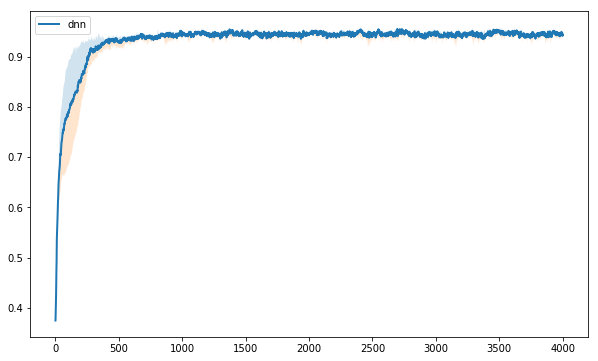

In [39]:
print("Tripod 3DOF")
fig, ax1 = plt.subplots(1,sharex=True,figsize=(10,6))
plot_data_from(neat_33_fld,3,"neat",9,4001,"dnn",ax1)
plt.legend()
plt.show()

Plot of number of neurons and connections in DNN
legged_robot_novelty_neat_three_legs_3dof_long_eval_12_8_20-41-58
legged_robot_novelty_neat_three_legs_3dof_long_eval_13_8_23-33-52
legged_robot_novelty_neat_three_legs_3dof_long_eval_16_8_7-1-9
legged_robot_novelty_neat_three_legs_3dof_long_eval_15_8_4-8-12
legged_robot_novelty_neat_three_legs_3dof_long_eval_13_8_10-14-51
legged_robot_novelty_neat_three_legs_3dof_long_eval_15_8_17-11-25
legged_robot_novelty_neat_three_legs_3dof_long_eval_14_8_13-39-13
legged_robot_novelty_neat_three_legs_3dof_long_eval_12_8_7-47-15
legged_robot_novelty_neat_three_legs_3dof_long_eval_16_8_21-10-56


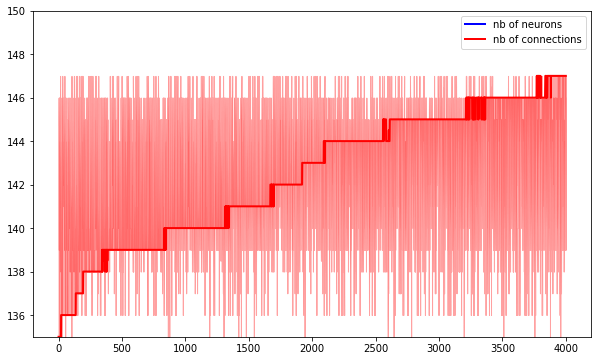

legged_robot_novelty_neat_three_legs_3dof_long_eval_12_8_20-41-58
legged_robot_novelty_neat_three_legs_3dof_long_eval_13_8_23-33-52
legged_robot_novelty_neat_three_legs_3dof_long_eval_16_8_7-1-9
legged_robot_novelty_neat_three_legs_3dof_long_eval_15_8_4-8-12
legged_robot_novelty_neat_three_legs_3dof_long_eval_13_8_10-14-51
legged_robot_novelty_neat_three_legs_3dof_long_eval_15_8_17-11-25
legged_robot_novelty_neat_three_legs_3dof_long_eval_14_8_13-39-13
legged_robot_novelty_neat_three_legs_3dof_long_eval_12_8_7-47-15
legged_robot_novelty_neat_three_legs_3dof_long_eval_16_8_21-10-56


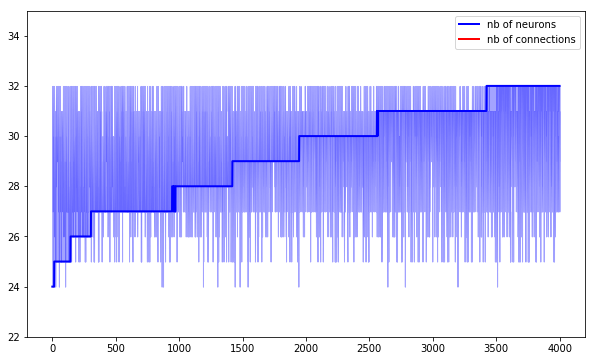

In [43]:
print("Plot of number of neurons and connections in DNN")
fig, ax1 = plt.subplots(1,sharex=True,figsize=(10,6))
ax1.set_ylim([135,150])
plot_dnn_data_from(neat_33_fld,3,"neat",4001,400,ax1)
plt.legend()
plt.show()
fig, ax1 = plt.subplots(1,sharex=True,figsize=(10,6))
ax1.set_ylim([22,35])
plot_dnn_data_from(neat_33_fld,3,"neat",4001,400,ax1)
plt.legend()
plt.show()

nb points: 400 min=(-4.89, -4.94) max=(4.88,4.95)


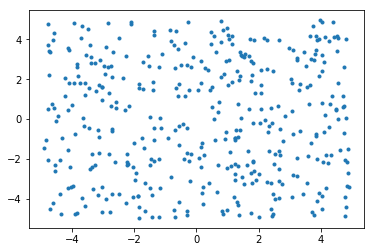

nb points: 400 min=(-4.94, -4.94) max=(4.95,4.92)


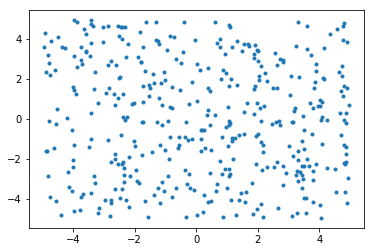

nb points: 400 min=(-4.95, -4.24) max=(4.77,4.93)


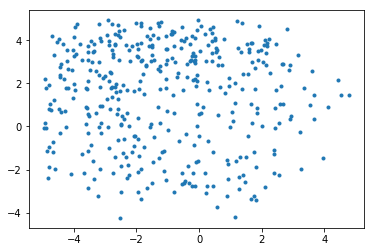

nb points: 400 min=(-4.92, -4.94) max=(4.92,4.92)


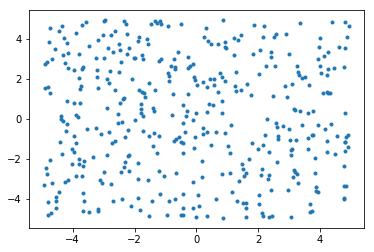

nb points: 400 min=(-4.94, -4.89) max=(4.93,4.88)


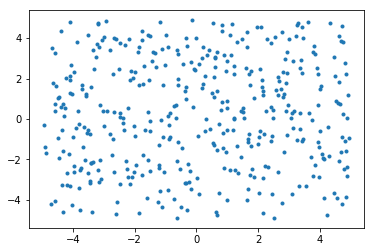

nb points: 400 min=(-4.85, -4.79) max=(4.92,4.89)


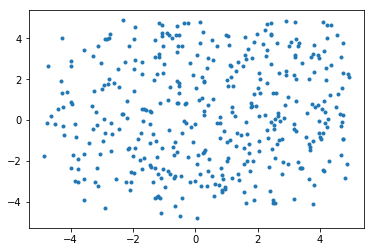

nb points: 400 min=(-4.87, -4.84) max=(4.87,4.90)


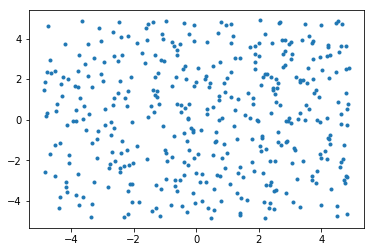

nb points: 400 min=(-4.93, -4.92) max=(4.91,4.91)


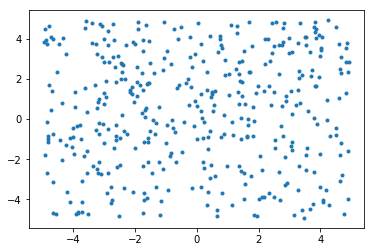

nb points: 400 min=(-4.91, -4.89) max=(4.92,4.91)


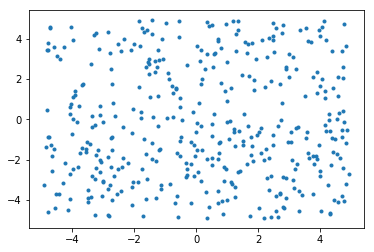

In [50]:
for folder in os.listdir(neat_33_fld) :
    plot_map(neat_33_fld + '/' + folder + '/bd_004000.log' ,3)

In [9]:
neat_32_fld = "/home/leni/sferes_log/legged_robot_exp/first_run_neat_32/"

Tripod 2DOF
legged_robot_novelty_neat_three_legs_2dof_long_eval_21_8_16-42-33
legged_robot_novelty_neat_three_legs_2dof_long_eval_18_8_11-41-12
legged_robot_novelty_neat_three_legs_2dof_long_eval_19_8_8-9-3
legged_robot_novelty_neat_three_legs_2dof_long_eval_18_8_21-33-58
legged_robot_novelty_neat_three_legs_2dof_long_eval_19_8_18-34-0
legged_robot_novelty_neat_three_legs_2dof_long_eval_20_8_11-59-18
legged_robot_novelty_neat_three_legs_2dof_long_eval_21_8_7-20-7


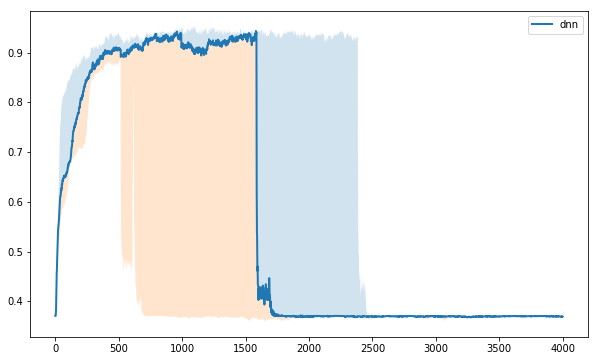

In [10]:
print("Tripod 2DOF")
fig, ax1 = plt.subplots(1,sharex=True,figsize=(10,6))
plot_data_from(neat_32_fld,3,"neat",9,4001,"dnn",ax1)
plt.legend()
plt.show()

Plot of number of neurons and connections in DNN
legged_robot_novelty_neat_three_legs_2dof_long_eval_21_8_16-42-33
legged_robot_novelty_neat_three_legs_2dof_long_eval_18_8_11-41-12
legged_robot_novelty_neat_three_legs_2dof_long_eval_19_8_8-9-3
legged_robot_novelty_neat_three_legs_2dof_long_eval_18_8_21-33-58
legged_robot_novelty_neat_three_legs_2dof_long_eval_19_8_18-34-0
legged_robot_novelty_neat_three_legs_2dof_long_eval_20_8_11-59-18
legged_robot_novelty_neat_three_legs_2dof_long_eval_21_8_7-20-7


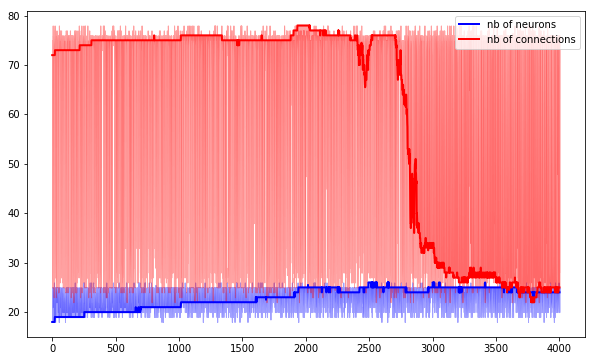

legged_robot_novelty_neat_three_legs_2dof_long_eval_21_8_16-42-33
legged_robot_novelty_neat_three_legs_2dof_long_eval_18_8_11-41-12
legged_robot_novelty_neat_three_legs_2dof_long_eval_19_8_8-9-3
legged_robot_novelty_neat_three_legs_2dof_long_eval_18_8_21-33-58
legged_robot_novelty_neat_three_legs_2dof_long_eval_19_8_18-34-0
legged_robot_novelty_neat_three_legs_2dof_long_eval_20_8_11-59-18
legged_robot_novelty_neat_three_legs_2dof_long_eval_21_8_7-20-7


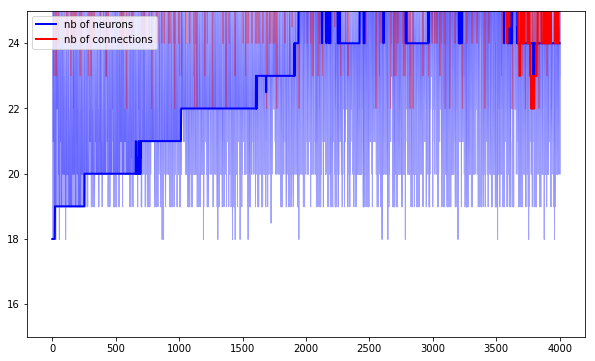

In [11]:
print("Plot of number of neurons and connections in DNN")
fig, ax1 = plt.subplots(1,sharex=True,figsize=(10,6))
#ax1.set_ylim([80,150])
plot_dnn_data_from(neat_32_fld,3,"neat",4001,400,ax1)
plt.legend()
plt.show()
fig, ax1 = plt.subplots(1,sharex=True,figsize=(10,6))
ax1.set_ylim([15,25])
plot_dnn_data_from(neat_32_fld,3,"neat",4001,400,ax1)
plt.legend()
plt.show()

nb points: 400 min=(-4.94, -4.92) max=(4.93,4.92)


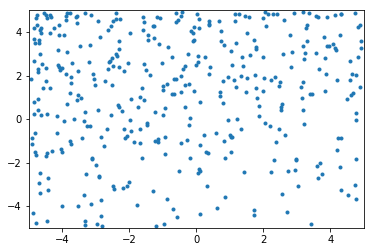

nb points: 400 min=(-0.43, -0.48) max=(0.54,0.42)


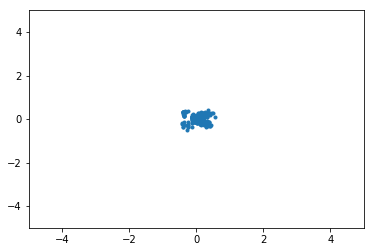

nb points: 400 min=(-0.36, -0.34) max=(0.46,0.46)


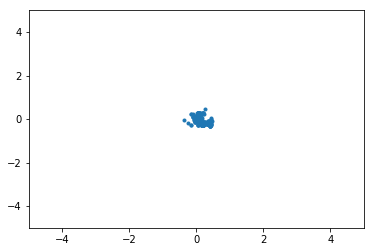

nb points: 400 min=(-0.49, -0.62) max=(0.50,0.43)


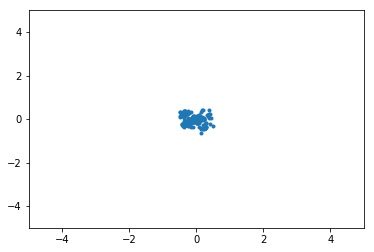

nb points: 400 min=(-0.52, -0.48) max=(0.35,0.34)


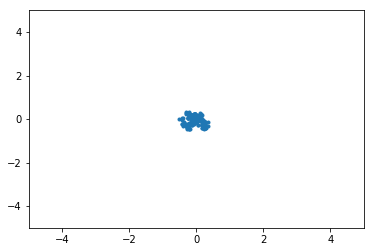

nb points: 400 min=(-0.44, -0.43) max=(0.59,0.49)


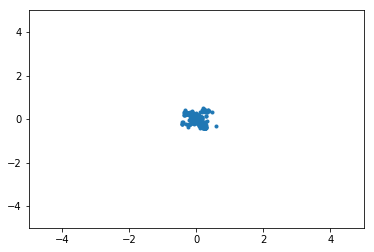

nb points: 400 min=(-0.48, -0.40) max=(0.57,0.33)


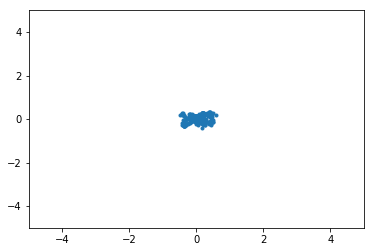

In [12]:
for folder in os.listdir(neat_32_fld) :
    plot_map(neat_32_fld + '/' + folder + '/bd_004000.log' ,3)

In [6]:
neat_34_fld = "/home/leni/sferes_log/legged_robot_exp/neat_34/"

Tripod 4DOF
legged_robot_novelty_neat_three_legs_4dof_long_eval_28_8_19-9-3
legged_robot_novelty_neat_three_legs_4dof_long_eval_26_8_11-19-50
legged_robot_novelty_neat_three_legs_4dof_long_eval_27_8_5-52-19
legged_robot_novelty_neat_three_legs_4dof_long_eval_28_8_0-1-19
legged_robot_novelty_neat_three_legs_4dof_long_eval_30_8_9-40-33
legged_robot_novelty_neat_three_legs_4dof_long_eval_25_8_16-47-25
legged_robot_novelty_neat_three_legs_4dof_long_eval_24_8_20-18-32
legged_robot_novelty_neat_three_legs_4dof_long_eval_1_9_3-9-30
legged_robot_novelty_neat_three_legs_4dof_long_eval_29_8_16-6-18
legged_robot_novelty_neat_three_legs_4dof_long_eval_1_9_22-37-54


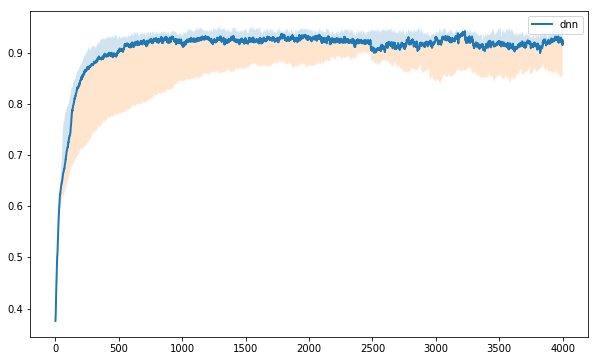

In [9]:
print("Tripod 4DOF")
fig, ax1 = plt.subplots(1,sharex=True,figsize=(10,6))
plot_data_from(neat_34_fld,3,"neat",10,4001,"dnn",ax1)
plt.legend()
plt.show()

Plot of number of neurons and connections in DNN
legged_robot_novelty_neat_three_legs_4dof_long_eval_28_8_19-9-3
legged_robot_novelty_neat_three_legs_4dof_long_eval_26_8_11-19-50
legged_robot_novelty_neat_three_legs_4dof_long_eval_27_8_5-52-19
legged_robot_novelty_neat_three_legs_4dof_long_eval_28_8_0-1-19
legged_robot_novelty_neat_three_legs_4dof_long_eval_30_8_9-40-33
legged_robot_novelty_neat_three_legs_4dof_long_eval_25_8_16-47-25
legged_robot_novelty_neat_three_legs_4dof_long_eval_24_8_20-18-32
legged_robot_novelty_neat_three_legs_4dof_long_eval_1_9_3-9-30
legged_robot_novelty_neat_three_legs_4dof_long_eval_29_8_16-6-18
legged_robot_novelty_neat_three_legs_4dof_long_eval_1_9_22-37-54


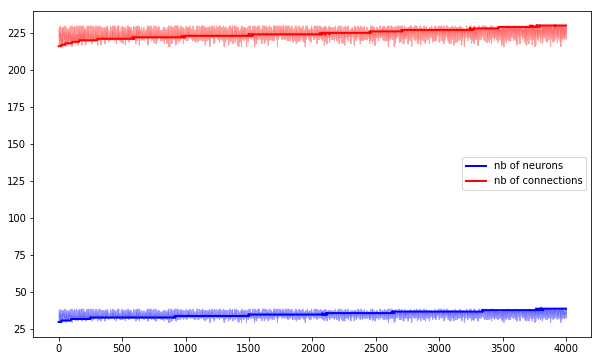

legged_robot_novelty_neat_three_legs_4dof_long_eval_28_8_19-9-3
legged_robot_novelty_neat_three_legs_4dof_long_eval_26_8_11-19-50
legged_robot_novelty_neat_three_legs_4dof_long_eval_27_8_5-52-19
legged_robot_novelty_neat_three_legs_4dof_long_eval_28_8_0-1-19
legged_robot_novelty_neat_three_legs_4dof_long_eval_30_8_9-40-33
legged_robot_novelty_neat_three_legs_4dof_long_eval_25_8_16-47-25
legged_robot_novelty_neat_three_legs_4dof_long_eval_24_8_20-18-32
legged_robot_novelty_neat_three_legs_4dof_long_eval_1_9_3-9-30
legged_robot_novelty_neat_three_legs_4dof_long_eval_29_8_16-6-18
legged_robot_novelty_neat_three_legs_4dof_long_eval_1_9_22-37-54


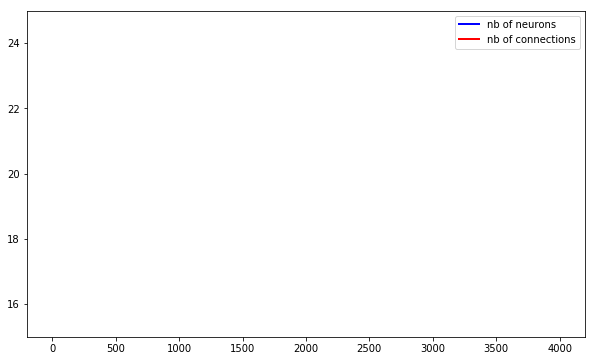

In [10]:
print("Plot of number of neurons and connections in DNN")
fig, ax1 = plt.subplots(1,sharex=True,figsize=(10,6))
#ax1.set_ylim([80,150])
plot_dnn_data_from(neat_34_fld,3,"neat",4001,400,ax1)
plt.legend()
plt.show()
fig, ax1 = plt.subplots(1,sharex=True,figsize=(10,6))
ax1.set_ylim([15,25])
plot_dnn_data_from(neat_34_fld,3,"neat",4001,400,ax1)
plt.legend()
plt.show()

nb points: 400 min=(-0.73, -0.52) max=(0.48,0.35)


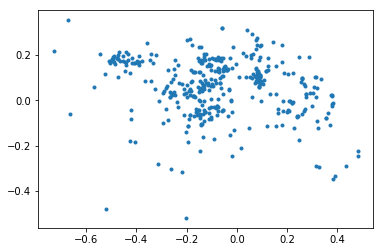

nb points: 400 min=(-4.88, -4.24) max=(4.33,4.73)


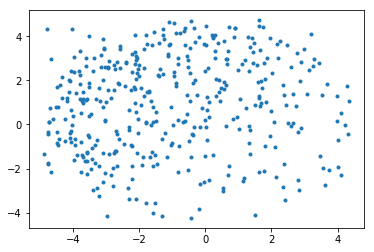

nb points: 400 min=(-4.88, -4.95) max=(4.91,4.95)


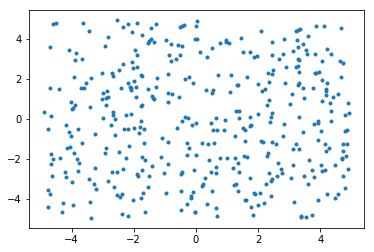

nb points: 400 min=(-4.53, -4.81) max=(4.62,4.70)


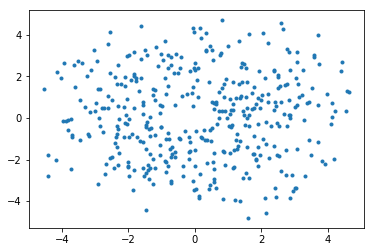

nb points: 400 min=(-4.89, -4.86) max=(4.95,4.93)


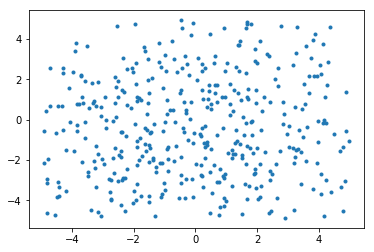

nb points: 400 min=(-4.88, -4.86) max=(4.87,4.87)


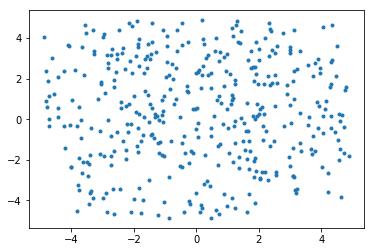

nb points: 400 min=(-4.87, -4.92) max=(4.92,4.92)


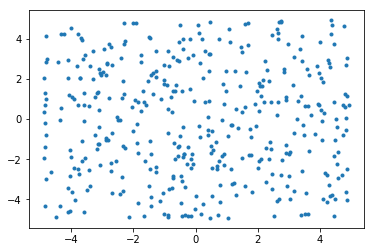

nb points: 400 min=(-4.84, -4.83) max=(4.91,4.88)


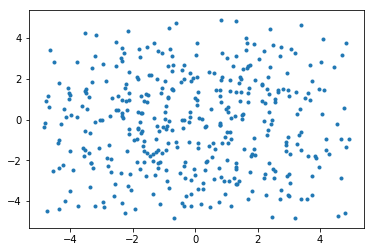

nb points: 400 min=(-4.95, -4.92) max=(4.91,4.93)


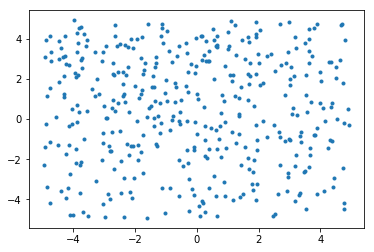

nb points: 400 min=(-4.90, -4.19) max=(4.76,4.68)


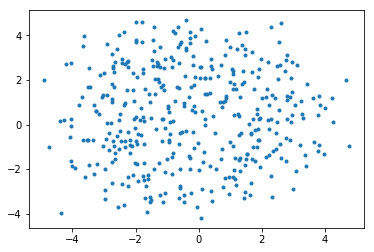

In [13]:
for folder in os.listdir(neat_34_fld) :
    plot_map(neat_34_fld + '/' + folder + '/bd_004000.log' ,3)

In [13]:
neat_32_fld = "/home/leni/sferes_log/legged_robot_exp/second_run_neat_32/"

Tripod 2DOF
legged_robot_novelty_neat_three_legs_2dof_long_eval_10_9_5-57-23
legged_robot_novelty_neat_three_legs_2dof_long_eval_11_9_3-36-9
legged_robot_novelty_neat_three_legs_2dof_long_eval_9_9_20-47-29
legged_robot_novelty_neat_three_legs_2dof_long_eval_11_9_21-21-20
legged_robot_novelty_neat_three_legs_2dof_long_eval_10_9_16-42-31
legged_robot_novelty_neat_three_legs_2dof_long_eval_9_9_2-8-18
legged_robot_novelty_neat_three_legs_2dof_long_eval_8_9_15-58-57
legged_robot_novelty_neat_three_legs_2dof_long_eval_11_9_11-12-22
legged_robot_novelty_neat_three_legs_2dof_long_eval_9_9_11-37-27
legged_robot_novelty_neat_three_legs_2dof_long_eval_12_9_7-49-44


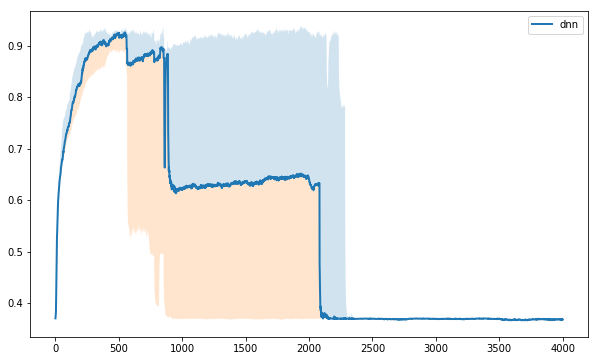

In [18]:
print("Tripod 2DOF")
fig, ax1 = plt.subplots(1,sharex=True,figsize=(10,6))
plot_data_from(neat_32_fld,3,"neat",10,4001,"dnn",ax1)
plt.legend()
plt.show()

Plot of number of neurons and connections in DNN
legged_robot_novelty_neat_three_legs_2dof_long_eval_10_9_5-57-23
legged_robot_novelty_neat_three_legs_2dof_long_eval_11_9_3-36-9
legged_robot_novelty_neat_three_legs_2dof_long_eval_9_9_20-47-29
legged_robot_novelty_neat_three_legs_2dof_long_eval_11_9_21-21-20
legged_robot_novelty_neat_three_legs_2dof_long_eval_10_9_16-42-31
legged_robot_novelty_neat_three_legs_2dof_long_eval_9_9_2-8-18
legged_robot_novelty_neat_three_legs_2dof_long_eval_8_9_15-58-57
legged_robot_novelty_neat_three_legs_2dof_long_eval_11_9_11-12-22
legged_robot_novelty_neat_three_legs_2dof_long_eval_9_9_11-37-27
legged_robot_novelty_neat_three_legs_2dof_long_eval_12_9_7-49-44


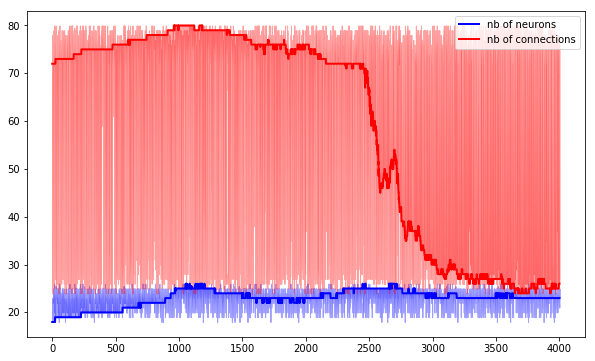

legged_robot_novelty_neat_three_legs_2dof_long_eval_10_9_5-57-23
legged_robot_novelty_neat_three_legs_2dof_long_eval_11_9_3-36-9
legged_robot_novelty_neat_three_legs_2dof_long_eval_9_9_20-47-29
legged_robot_novelty_neat_three_legs_2dof_long_eval_11_9_21-21-20
legged_robot_novelty_neat_three_legs_2dof_long_eval_10_9_16-42-31
legged_robot_novelty_neat_three_legs_2dof_long_eval_9_9_2-8-18
legged_robot_novelty_neat_three_legs_2dof_long_eval_8_9_15-58-57
legged_robot_novelty_neat_three_legs_2dof_long_eval_11_9_11-12-22
legged_robot_novelty_neat_three_legs_2dof_long_eval_9_9_11-37-27
legged_robot_novelty_neat_three_legs_2dof_long_eval_12_9_7-49-44


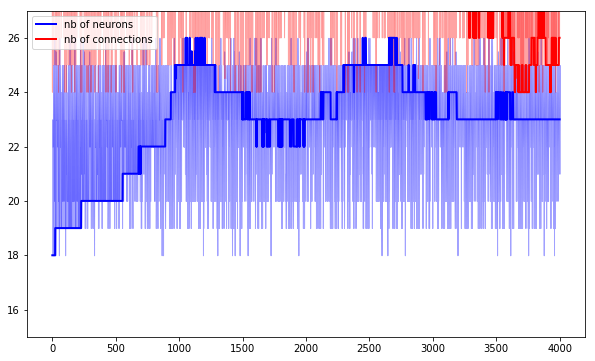

In [20]:
print("Plot of number of neurons and connections in DNN")
fig, ax1 = plt.subplots(1,sharex=True,figsize=(10,6))
#ax1.set_ylim([80,150])
plot_dnn_data_from(neat_32_fld,3,"neat",4001,400,ax1)
plt.legend()
plt.show()
fig, ax1 = plt.subplots(1,sharex=True,figsize=(10,6))
ax1.set_ylim([15,27])
plot_dnn_data_from(neat_32_fld,3,"neat",4001,400,ax1)
plt.legend()
plt.show()

nb points: 400 min=(-0.51, -0.40) max=(0.53,0.38)


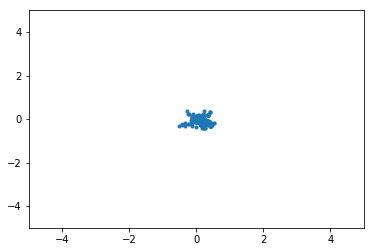

nb points: 400 min=(-4.89, -4.90) max=(4.95,4.86)


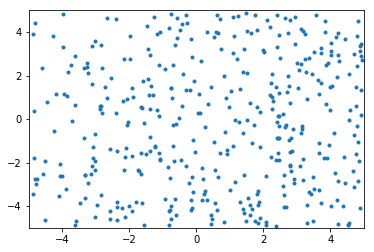

nb points: 400 min=(-4.92, -4.94) max=(4.95,4.93)


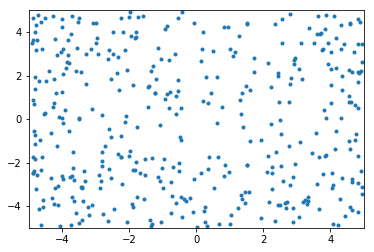

nb points: 400 min=(-0.39, -0.40) max=(0.57,0.46)


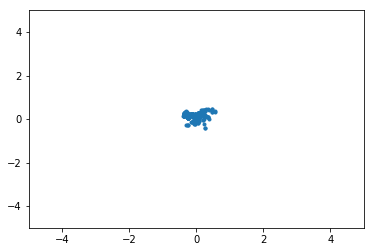

nb points: 400 min=(-0.42, -0.46) max=(0.48,0.27)


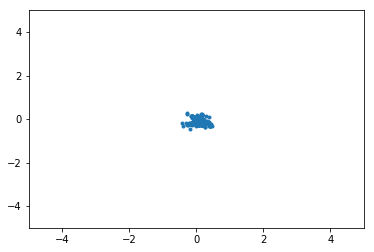

nb points: 400 min=(-0.50, -0.46) max=(0.58,0.43)


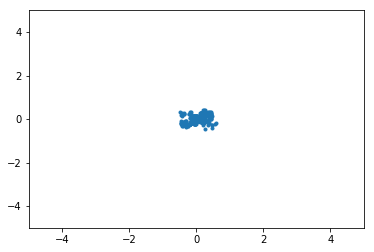

nb points: 400 min=(-0.41, -0.34) max=(0.41,0.46)


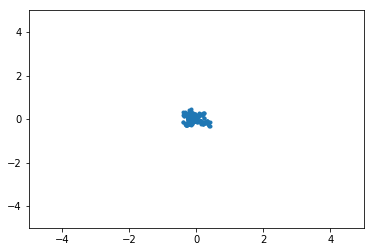

nb points: 400 min=(-0.39, -0.49) max=(0.49,0.40)


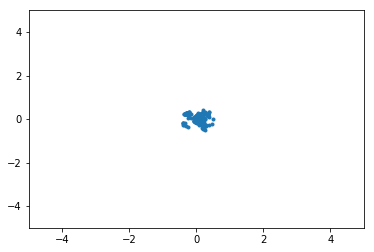

nb points: 400 min=(-0.54, -0.41) max=(0.52,0.47)


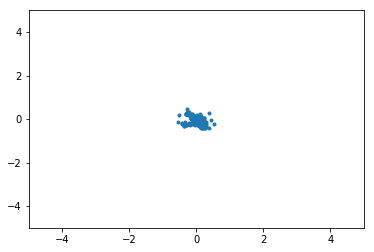

nb points: 400 min=(-0.35, -0.49) max=(0.45,0.34)


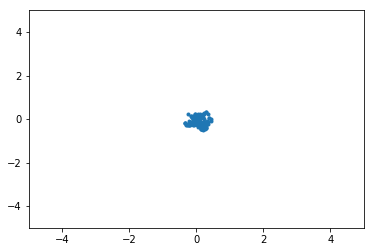

In [21]:
for folder in os.listdir(neat_32_fld) :
    plot_map(neat_32_fld + '/' + folder + '/bd_004000.log' ,3)